<div align="center">
  <h1 style="color:#1976d2;"><b>Командная работа</b></h1>
  <p><b>По дисциплине: Машинное обучение и большие данные</b></p>
  <p><i>Мухитова Азалия, Каспранов Камиль — 22П-2</i></p>
</div>

### План выполнения работы

#### 1. Определение структуры данных
- **Выбор ключевых атрибутов**
  - Анализ релевантности признаков для задачи классификации
  - Идентификация наиболее информативных признаков
- **Обоснование включения/исключения данных**
  - Удаление избыточных признаков
  - Сохранение семантически значимых атрибутов

#### 2. Предобработка текста
- **Очистка текста:**
  - Удаление стоп-слов, спецсимволов, лишних пробелов
  - Приведение к нижнему регистру
  - Лемматизация и стемминг
  - Нормализация текстовых данных

#### 3. Тематическое моделирование
- Анализ ключевых слов
- Визуализация

#### 4. Векторизация текста
- **Преобразование текста в числовые векторы:**
  - TF-IDF (Term Frequency-Inverse Document Frequency)
  - Настройка параметров векторизации

#### 5. Классификация ансамблевыми методами
- **Стекинг (Stacking)**
- **Бэггинг (Bagging)**
- **Бустинг (Boosting)**

#### 6. Оценка результатов
- **Метрики качества:**
  - Accuracy, Precision, Recall, F1-Score
  - Матрицы ошибок (Confusion Matrix)
- **Сравнение производительности моделей**
- **Интерпретация результатов**

In [14]:
import pandas as pd
import string
import re
import numpy as np
import nltk
import pymorphy3

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ROG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ROG\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [34]:
df =pd.read_csv("real_estate_data.csv")


C:\Users\ROG\AppData\Local\Temp\ipykernel_8944\1324543836.py:1: DtypeWarning: Columns (9,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df =pd.read_csv("real_estate_data.csv")


In [35]:
df.head()

,id,type,sub_type,start_date,end_date,listing_type,tom,building_age,total_floor_count,floor_no,room_count,size,address,furnished,heating_type,price,price_currency
0,1,Konut,Rezidans,12/10/18,1/9/19,2,30,0,20 ve üzeri,2,2+1,90.0,İstanbul/Kartal/Kordonboyu,NaN,Fancoil,3500.0,TRY
1,2,Konut,Daire,2/13/19,NaN,1,14,0,20 ve üzeri,20 ve üzeri,1+0,43.0,İstanbul/Kartal/Kordonboyu,NaN,Fancoil,490000.0,TRY
2,3,Konut,Daire,10/9/18,11/8/18,1,30,0,1,Yüksek Giriş,2+1,NaN,Tekirdağ/Çorlu/Reşadiye,NaN,Fancoil,155000.0,TRY
3,4,Konut,Rezidans,9/10/18,10/10/18,1,30,3,20 ve üzeri,20 ve üzeri,6+1,450.0,İstanbul/Beşiktaş/Levent,NaN,Fancoil,32500000.0,TRY
4,5,Konut,Rezidans,12/10/18,1/9/19,1,30,0,20 ve üzeri,2,2+1,90.0,İstanbul/Kartal/Kordonboyu,NaN,Fancoil,1450000.0,TRY


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403487 entries, 0 to 403486
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 403487 non-null  int64  
 1   type               403487 non-null  object 
 2   sub_type           403487 non-null  object 
 3   start_date         403487 non-null  object 
 4   end_date           266298 non-null  object 
 5   listing_type       403487 non-null  int64  
 6   tom                403487 non-null  int64  
 7   building_age       376097 non-null  object 
 8   total_floor_count  375466 non-null  object 
 9   floor_no           368191 non-null  object 
 10  room_count         403487 non-null  object 
 11  size               257481 non-null  float64
 12  address            403487 non-null  object 
 13  furnished          0 non-null       float64
 14  heating_type       375517 non-null  object 
 15  price              402772 non-null  float64
 16  pr

В датасете 403487 записей и 17 столбцов.
Большинство признаков заполнены, но есть пропуски.
Столбец furnished полностью пустой и не несёт информации.
Данные содержат как числовые, так и категориальные признаки.

___

### Описание структуры датасета недвижимости

| № | Столбец | Описание |
|---|---------|----------|
| 1 | `id` | Уникальный идентификатор объекта недвижимости |
| 2 | `type` | Тип свойства: `Konut` (Жилье) |
| 3 | `sub_type` | Подтип свойства: `Daire` (Квартира), `Rezidans` (Жилой комплекс) |
| 4 | `start_date` | Дата начала активности объявления |
| 5 | `end_date` | Дата окончания активности объявления (если применимо) |
| 6 | `listing_type` | Тип листинга: `1` - Продажа, `2` - Аренда |
| 7 | `tom` | Время на рынке (в днях) |
| 8 | `building_age` | Возраст здания (текстовое описание) |
| 9 | `total_floor_count` | Общее количество этажей в здании |
| 10 | `floor_no` | Номер этажа объекта |
| 11 | `room_count` | Количество комнат (формат: "2+1") |
| 12 | `size` | Площадь объекта в м² |
| 13 | `address` | Адрес объекта (город/район/окружение) |
| 14 | `furnished` | Меблировка (всегда пусто) |
| 15 | `heating_type` | Тип отопления |
| 16 | `price` | Цена объекта |
| 17 | `price_currency` | Валюта цены: `TRY`, `USD`, `EUR` |

In [ ]:
# Удаление полностью пустых колонок
df.drop(columns=['furnished'], inplace=True, errors='ignore')

In [ ]:
# Обработка текстовых полей
def parse_room_count(room_str):
    """Парсинг формата комнат: 2+1, 3+1 и т.д."""
    if pd.isna(room_str):
        return np.nan
    
    room_str = str(room_str).strip()
    # Ищем паттерн типа "2+1", "3+1" и т.д.
    match = re.search(r'(\d+)\s*\+\s*(\d+)', room_str)
    if match:
        rooms = int(match.group(1))
        living_rooms = int(match.group(2))
        return rooms + living_rooms  # Общее количество комнат
    else:
        # Пробуем извлечь просто число
        try:
            return float(room_str)
        except:
            return np.nan

def parse_floor(floor_str):
    """Парсинг информации о этаже"""
    if pd.isna(floor_str):
        return np.nan
    
    floor_str = str(floor_str).strip().lower()
    
    # Специальные случаи этажей
    special_floors = {
        'yüksek giriş': 1,  # 1-й этаж
        'giriş kat': 0, 'kot1': 0, 'zemin kat': 0,  # цокольный этаж
        'çatı katı': -1,  # мансарда (помечаем специальным значением)
        'bahçe katı': -2   # садовый этаж
    }
    
    for key, value in special_floors.items():
        if key in floor_str:
            return value
    
    # Пробуем извлечь числовое значение
    try:
        return float(re.search(r'\d+', floor_str).group())
    except:
        return np.nan

def parse_building_age(age_str):
    """Парсинг возраста здания"""
    if pd.isna(age_str):
        return np.nan
    
    age_str = str(age_str).strip().lower()
    
    # Специальные категории
    if 'sıfır' in age_str or '0' in age_str:
        return 0  # Новостройка
    elif '1-5' in age_str or '1 ile 5' in age_str:
        return 3  # Среднее значение диапазона
    elif '6-10' in age_str:
        return 8
    elif '11-15' in age_str:
        return 13
    elif '16-20' in age_str:
        return 18
    elif '20+' in age_str or '21' in age_str:
        return 25  # Приблизительное значение для старых зданиях
    else:
        # Пробуем извлечь конкретное число
        try:
            return float(re.search(r'\d+', age_str).group())
        except:
            return np.nan

In [39]:
# Применяем парсинг к текстовым полям
df['room_count'] = df['room_count'].apply(parse_room_count)
df['floor_no'] = df['floor_no'].apply(parse_floor)
df['building_age_numeric'] = df['building_age'].apply(parse_building_age)

In [40]:
df.head()

,id,type,sub_type,start_date,end_date,listing_type,tom,building_age,total_floor_count,floor_no,room_count,size,address,heating_type,price,price_currency,building_age_numeric
0,1,Konut,Rezidans,12/10/18,1/9/19,2,30,0,20 ve üzeri,2.0,3.0,90.0,İstanbul/Kartal/Kordonboyu,Fancoil,3500.0,TRY,0.0
1,2,Konut,Daire,2/13/19,NaN,1,14,0,20 ve üzeri,20.0,1.0,43.0,İstanbul/Kartal/Kordonboyu,Fancoil,490000.0,TRY,0.0
2,3,Konut,Daire,10/9/18,11/8/18,1,30,0,1,1.0,3.0,NaN,Tekirdağ/Çorlu/Reşadiye,Fancoil,155000.0,TRY,0.0
3,4,Konut,Rezidans,9/10/18,10/10/18,1,30,3,20 ve üzeri,20.0,7.0,450.0,İstanbul/Beşiktaş/Levent,Fancoil,32500000.0,TRY,3.0
4,5,Konut,Rezidans,12/10/18,1/9/19,1,30,0,20 ve üzeri,2.0,3.0,90.0,İstanbul/Kartal/Kordonboyu,Fancoil,1450000.0,TRY,0.0


In [ ]:
# Обработка пропущенных значений
# Для числовых признаков
numeric_cols = ['size', 'price', 'room_count', 'floor_no', 'building_age_numeric']
for col in numeric_cols:
    if col in df.columns:
        df[col].fillna(df[col].median(), inplace=True)

# Для категориальных признаков
categorical_cols = ['heating_type', 'price_currency', 'building_age']
for col in categorical_cols:
    if col in df.columns:
        df[col].fillna('Unknown', inplace=True)

# Для дат
df['end_date'].fillna('Active', inplace=True)  # Активные объявления

C:\Users\ROG\AppData\Local\Temp\ipykernel_8944\502023392.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\ROG\AppData\Local\Temp\ipykernel_8944\502023392.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when

In [ ]:
# Преобразование типов данных
# Дата-время
df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')
df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce')

# Категориальные переменные с учетом турецких значений
categorical_mappings = {
    'type': {'Konut': 'Housing'},
    'sub_type': {'Daire': 'Flat'},
    'listing_type': {1: 'Sale', 2: 'Rent'},  # Предполагая кодировку
    'price_currency': {'TL': 'TRY', 'USD': 'USD', 'EUR': 'EUR'}
}

for col, mapping in categorical_mappings.items():
    if col in df.columns:
        df[col] = df[col].replace(mapping)
        df[col] = df[col].astype('category')

C:\Users\ROG\AppData\Local\Temp\ipykernel_8944\1028897613.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')
C:\Users\ROG\AppData\Local\Temp\ipykernel_8944\1028897613.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce')


In [43]:
df.head()

,id,type,sub_type,start_date,end_date,listing_type,tom,building_age,total_floor_count,floor_no,room_count,size,address,heating_type,price,price_currency,building_age_numeric
0,1,Housing,Rezidans,2018-12-10,2019-01-09,Rent,30,0,20 ve üzeri,2.0,3.0,90.0,İstanbul/Kartal/Kordonboyu,Fancoil,3500.0,TRY,0.0
1,2,Housing,Flat,2019-02-13,NaT,Sale,14,0,20 ve üzeri,20.0,1.0,43.0,İstanbul/Kartal/Kordonboyu,Fancoil,490000.0,TRY,0.0
2,3,Housing,Flat,2018-10-09,2018-11-08,Sale,30,0,1,1.0,3.0,110.0,Tekirdağ/Çorlu/Reşadiye,Fancoil,155000.0,TRY,0.0
3,4,Housing,Rezidans,2018-09-10,2018-10-10,Sale,30,3,20 ve üzeri,20.0,7.0,450.0,İstanbul/Beşiktaş/Levent,Fancoil,32500000.0,TRY,3.0
4,5,Housing,Rezidans,2018-12-10,2019-01-09,Sale,30,0,20 ve üzeri,2.0,3.0,90.0,İstanbul/Kartal/Kordonboyu,Fancoil,1450000.0,TRY,0.0


In [44]:
# Создание новых признаков
# Время на рынке в днях 
if 'start_date' in df.columns:
    current_date = pd.Timestamp.now()
    df['days_on_market'] = (current_date - df['start_date']).dt.days
    df['days_on_market'].fillna(df['days_on_market'].median(), inplace=True)

# Цена за квадратный метр
if all(col in df.columns for col in ['price', 'size']):
    df['price_per_sqm'] = df['price'] / df['size']
    # Убираем некорректные значения
    df = df[(df['price_per_sqm'] > 0) & (df['price_per_sqm'] != np.inf)]


C:\Users\ROG\AppData\Local\Temp\ipykernel_8944\361798596.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['days_on_market'].fillna(df['days_on_market'].median(), inplace=True)


###### В ходе предобработки данных были созданы новые признаки:

###### - **days_on_market** — количество дней, сколько объект находится на рынке. Этот признак помогает анализировать ликвидность недвижимости и выявлять объекты, которые долго не продаются или не сдаются.
###### - **price_per_sqm** — цена за квадратный метр. Позволяет сравнивать объекты между собой независимо от их общей площади, выявлять переоценённые и недооценённые предложения.
###### - **building_age_numeric** — числовое представление возраста здания, полученное из текстового описания. Упрощает анализ зависимости цены от возраста недвижимости.
###### - **room_count** — общее количество комнат, преобразованное из формата "2+1" в число. Стандартизирует данные для моделирования и сравнения объектов.
###### - **total_floor_count, floor_no** — числовые признаки, отражающие этажность здания и номер этажа, что важно для оценки привлекательности и стоимости объекта.

###### Эти признаки позволяют более точно анализировать рынок недвижимости, строить модели прогнозирования цены и выявлять закономерности в данных.

In [50]:
# Удаляем выбросы в столбце "price", учитывая тип недвижимости.
def remove_price_outliers(df):
    """Удаление выбросов в цене с учетом типа недвижимости"""
    if 'price' not in df.columns or 'sub_type' not in df.columns:
        return df
    
    # Убираем явно ошибочные значения
    df = df[df['price'] > 100]  # Минимальная цена

        # Убираем крайние выбросы по квартирному типу
    if 'Flat' in df['sub_type'].values:
        flat_mask = df['sub_type'] == 'Flat'
        df_flat = df[flat_mask]
        if len(df_flat) > 0:
            Q1 = df_flat['price'].quantile(0.01)
            Q3 = df_flat['price'].quantile(0.99)
            df = df[~flat_mask | ((df['price'] >= Q1) & (df['price'] <= Q3))]
    
    return df

In [51]:
df = remove_price_outliers(df)

In [52]:
df.head()

,id,type,sub_type,start_date,end_date,listing_type,tom,building_age,total_floor_count,floor_no,room_count,size,address,heating_type,price,price_currency,building_age_numeric,days_on_market,price_per_sqm
0,1,Housing,Rezidans,2018-12-10,2019-01-09,Rent,30,0,20.0,2.0,3.0,90.0,İstanbul/Kartal/Kordonboyu,Fancoil,3500.0,TRY,0.0,2457,38.888889
1,2,Housing,Flat,2019-02-13,NaT,Sale,14,0,20.0,20.0,1.0,43.0,İstanbul/Kartal/Kordonboyu,Fancoil,490000.0,TRY,0.0,2392,11395.348837
2,3,Housing,Flat,2018-10-09,2018-11-08,Sale,30,0,1.0,1.0,3.0,110.0,Tekirdağ/Çorlu/Reşadiye,Fancoil,155000.0,TRY,0.0,2519,1409.090909
3,4,Housing,Rezidans,2018-09-10,2018-10-10,Sale,30,3,20.0,20.0,7.0,450.0,İstanbul/Beşiktaş/Levent,Fancoil,32500000.0,TRY,3.0,2548,72222.222222
4,5,Housing,Rezidans,2018-12-10,2019-01-09,Sale,30,0,20.0,2.0,3.0,90.0,İstanbul/Kartal/Kordonboyu,Fancoil,1450000.0,TRY,0.0,2457,16111.111111


In [48]:
# Извлекаем первое число из строки val, возвращаем NaN если не получается
def parse_total_floor_count(val):
    if pd.isna(val): return np.nan
    try:
        return int(re.search(r'\d+', str(val)).group())
    except:
        return np.nan

if 'total_floor_count' in df.columns:
    df['total_floor_count'] = df['total_floor_count'].apply(parse_total_floor_count)
    df['total_floor_count'].fillna(df['total_floor_count'].median(), inplace=True)

C:\Users\ROG\AppData\Local\Temp\ipykernel_8944\4092891207.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['total_floor_count'].fillna(df['total_floor_count'].median(), inplace=True)


In [54]:
# Проверка пропусков и базовая статистика
print('Пропуски по столбцам:')
print(df.isnull().sum())
print('Статистика по цене:')
print(df['price'].describe())

Пропуски по столбцам:
id                           0
type                         0
sub_type                     0
start_date                   0
end_date                132481
listing_type                 0
tom                          0
building_age                 0
total_floor_count            0
floor_no                     0
room_count                   0
size                         0
address                      0
heating_type                 0
price                        0
price_currency               0
building_age_numeric         0
days_on_market               0
price_per_sqm                0
dtype: int64
Статистика по цене:
count    3.901200e+05
mean     3.142293e+05
std      3.126988e+06
min      1.200000e+02
25%      2.950000e+03
50%      1.990000e+05
75%      3.300000e+05
max      1.650000e+09
Name: price, dtype: float64


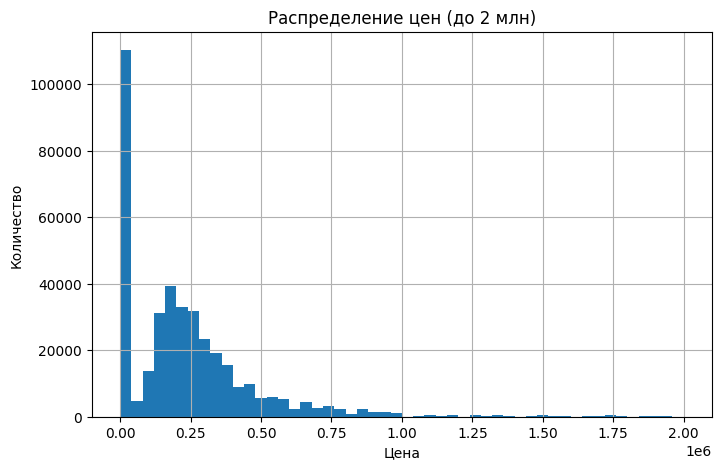

In [58]:
# Визуализация распределения цен с ограничением
plt.figure(figsize=(8,5))
df[df['price'] < 2000000]['price'].hist(bins=50)
plt.title('Распределение цен (до 2 млн)')
plt.xlabel('Цена')
plt.ylabel('Количество')
plt.show()

In [60]:
# Удаляем ненужные столбцы
drop_cols = [
    'id', 'address', 'start_date', 'end_date', 'tom', 'building_age',
    'sub_type', 'type', 'listing_type', 'price_currency', 'furnished'
]
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)
df.head()

,total_floor_count,floor_no,room_count,size,heating_type,price,building_age_numeric,days_on_market,price_per_sqm
0,20.0,2.0,3.0,90.0,Fancoil,3500.0,0.0,2457,38.888889
1,20.0,20.0,1.0,43.0,Fancoil,490000.0,0.0,2392,11395.348837
2,1.0,1.0,3.0,110.0,Fancoil,155000.0,0.0,2519,1409.090909
3,20.0,20.0,7.0,450.0,Fancoil,32500000.0,3.0,2548,72222.222222
4,20.0,2.0,3.0,90.0,Fancoil,1450000.0,0.0,2457,16111.111111


###### Удаляем именно эти столбцы, потому что они не несут полезной информации для дальнейшего анализа.

##### После удаления ненужных столбцов в таблице остались следующие признаки:

- total_floor_count — общее количество этажей в здании

- floor_no — этаж, на котором находится объект

- room_count — количество комнат

- size — площадь объекта

- heating_type — тип отопления

- price — цена

- building_age_numeric — возраст здания (числовой признак)

- days_on_market — количество дней на рынке

- price_per_sqm — цена за квадратный метр

In [64]:
# Удаляем все строки, где есть 'Unknown' в любом столбце
df = df[~df.apply(lambda row: row.astype(str).str.contains('Unknown').any(), axis=1)]

___

### Визуализация оставшихся столбцов

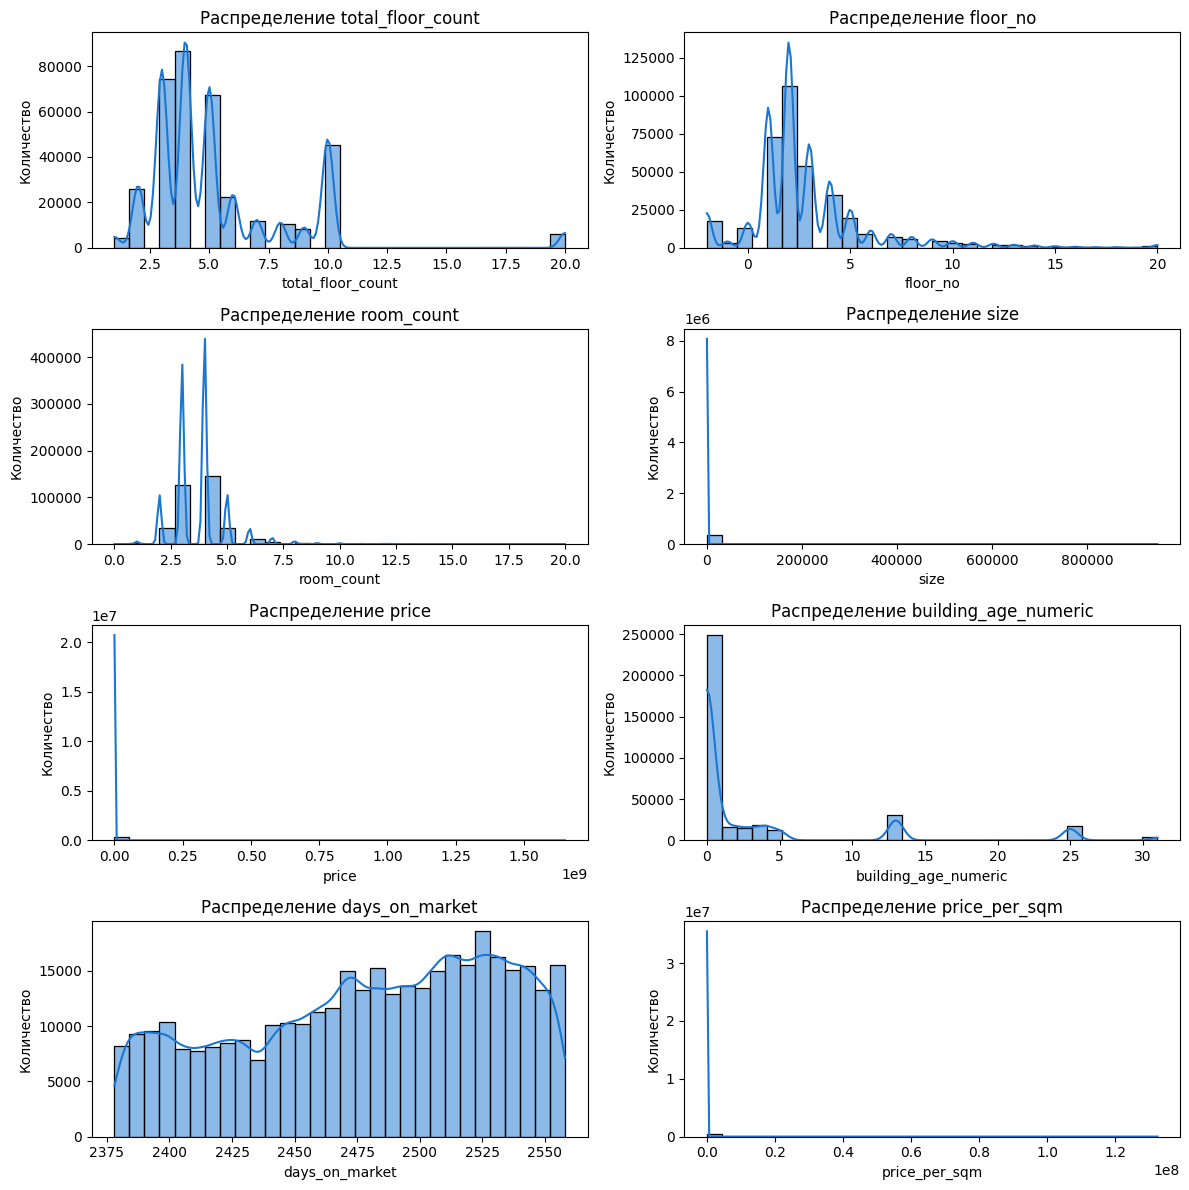

C:\Users\ROG\AppData\Local\Temp\ipykernel_8944\1456613240.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['heating_type'], palette='coolwarm')


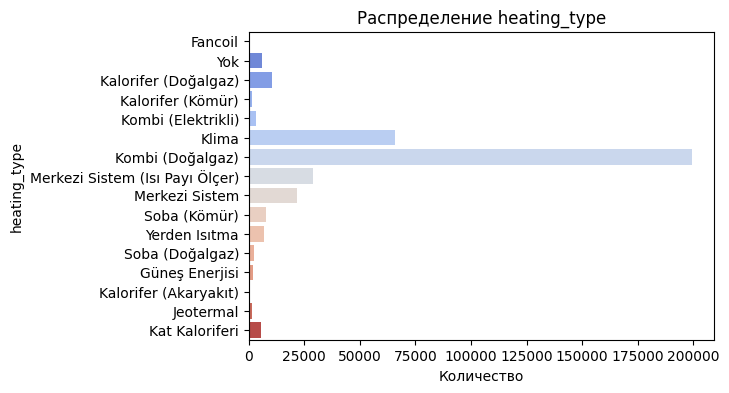

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = ['total_floor_count', 'floor_no', 'room_count', 'size', 'price', 'building_age_numeric', 'days_on_market', 'price_per_sqm']
categorical_cols = ['heating_type']

plt.figure(figsize=(12, 12))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(4, 2, i)
    sns.histplot(df[col], bins=30, kde=True, color='#1976d2')
    plt.title(f'Распределение {col}')
    plt.xlabel(col)
    plt.ylabel('Количество')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(y=df['heating_type'], palette='coolwarm')
plt.title('Распределение heating_type')
plt.xlabel('Количество')
plt.show()

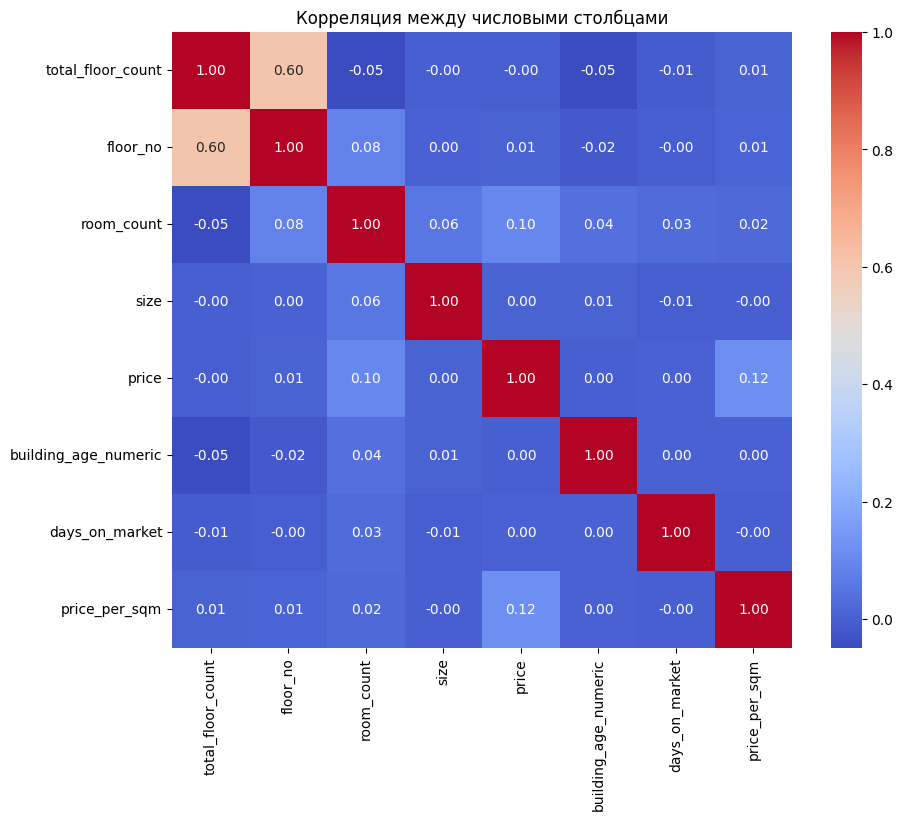

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Выбираем только числовые столбцы
numeric_cols = df.select_dtypes(include='number')

# Строим корреляционную матрицу
corr_matrix = numeric_cols.corr()

# Визуализируем тепловую карту
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Корреляция между числовыми столбцами')
plt.show()

###### floor_no и total_floor_count (0.61): этаж квартиры часто связан с общим числом этажей в доме (например, в домах с малым числом этажей редко бывают высокие этажи).

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 363250 entries, 0 to 375516
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   total_floor_count     363250 non-null  float64
 1   floor_no              363250 non-null  float64
 2   room_count            363250 non-null  float64
 3   size                  363250 non-null  float64
 4   heating_type          363250 non-null  object 
 5   price                 363250 non-null  float64
 6   building_age_numeric  363250 non-null  float64
 7   days_on_market        363250 non-null  int64  
 8   price_per_sqm         363250 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 27.7+ MB


___

### Ансамблевые методы